# Predecir el Puntaje de Recencia en Papers de Investigación
*Notebook created by Erick Calderin*

**Web site:** https://www.datasource.ai/es/home/data-science-competitions-for-startups/predecir-el-puntaje-de-recencia-en-papers-de-investigacion

## Modules

In [1]:
# Utilities

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import multiprocessing as mp
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# For ML
from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.decomposition import PCA

For NLP

In [4]:
# Install
!pip install -U spacy
!python -m spacy download en_core_web_sm
!python -m spacy download es_core_news_sm
!python -m spacy download pt_core_news_sm

  Attempting uninstall: spacy
    Found existing installation: spacy 3.1.1
    Uninstalling spacy-3.1.1:
      Successfully uninstalled spacy-3.1.1


You should consider upgrading via the 'c:\users\erick\anaconda3\python.exe -m pip install --upgrade pip' command.


[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


2021-08-31 01:37:03.303834: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library cudart64_110.dll
You should consider upgrading via the 'C:\Users\Erick\anaconda3\python.exe -m pip install --upgrade pip' command.


[+] Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')


2021-08-31 01:37:23.791077: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library cudart64_110.dll
You should consider upgrading via the 'C:\Users\Erick\anaconda3\python.exe -m pip install --upgrade pip' command.


[+] Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


2021-08-31 01:37:36.335597: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library cudart64_110.dll
You should consider upgrading via the 'C:\Users\Erick\anaconda3\python.exe -m pip install --upgrade pip' command.


In [3]:
import spacy
import re
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

## Importing data

Getting training and test datasets from Drive.

In [4]:
# Train
#PREFIX = '/content/drive/MyDrive/Colab Notebooks/CompetenciaPuntajeRecencia'
#train = pd.read_csv(PREFIX+'/Train.csv')
#test = pd.read_csv(PREFIX+'/Test.csv')

train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

## Exploring

In [5]:
train.head()

,id,Language,Year,Abstract,Title,total_rel_score
0,1,en,2016,The present study investigates an inventory mo...,Replenishment policy for non-instantaneous det...,0.630682
1,2,en,2019,AIM: To investigate the clinical characteristi...,Analysis of soldiers' orbital wall fracture su...,0.583333
2,3,en,2019,"Aflatoxin M1 (AFM1) and ochratoxin A (OTA), wh...","Modulation of Mucin (MUC2, MUC5AC and MUC5B) m...",0.372222
3,4,en,2017,Background/Aim: There are still unrevealed tre...,Traditional dentistry knowledge among Serbs in...,0.661765
4,5,en,2015,Impairment in empathy has been demonstrated in...,Dimensional schizotypy and social cognition: A...,0.373737


In [6]:
print('Train Shape', train.shape)
print('Test Shape', test.shape)

Train Shape (21456, 6)
Test Shape (10728, 5)


In [7]:
print('Unique languages\n', train.Language.value_counts())
print('\nAmount Unique Years', len(train.Year.value_counts()))

Unique languages
 en    18539
pt     1539
es     1378
Name: Language, dtype: int64

Amount Unique Years 59


No missing values!

In [8]:
train.isna().sum()

id                 0
Language           0
Year               0
Abstract           0
Title              0
total_rel_score    0
dtype: int64

Score distribution for each language

Text(0.5, 6.79999999999999, 'Scores')

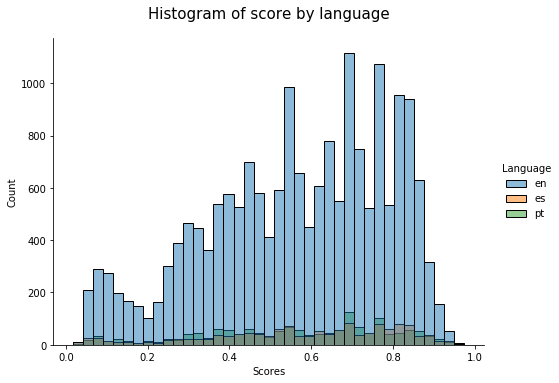

In [12]:
sns.displot(data=train, x= 'total_rel_score', aspect=1.4, hue='Language')
plt.title('Histogram of score by language', fontsize=15, pad=20)
plt.xlabel('Scores')

Plot above indicate us there is no outliers within data, another great new! However we can notice that papers at english language overcome to ones created in other languages.

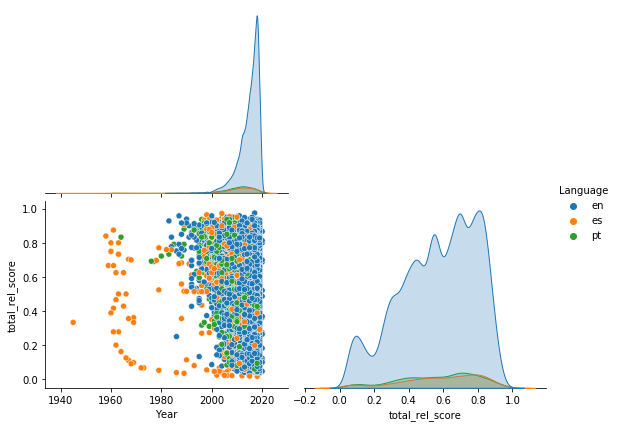

In [13]:
sns.pairplot(train.drop(columns=['id']), hue='Language', corner=True, aspect=1.3, height=3)

In another hand, there is a clear separation between papers at spanish language in early years and rest of papers.

## Preprocessing

### Creating dummy variables for Language

In [5]:
dummy_language = OneHotEncoder(dtype='int8')
df_dummy_language = dummy_language.fit_transform(train[['Language']]).toarray()

In [6]:
train = train.join(pd.DataFrame(df_dummy_language, columns=dummy_language.categories_[0]))

### MinMaxScaler to Year

In [7]:
minMaxScaler = MinMaxScaler()
year_minmax = minMaxScaler.fit_transform(train[['Year']])
train.Year = year_minmax

In [8]:
train.head()

,id,Language,Year,Abstract,Title,total_rel_score,en,es,pt
0,1,en,0.946667,The present study investigates an inventory mo...,Replenishment policy for non-instantaneous det...,0.630682,1,0,0
1,2,en,0.986667,AIM: To investigate the clinical characteristi...,Analysis of soldiers' orbital wall fracture su...,0.583333,1,0,0
2,3,en,0.986667,"Aflatoxin M1 (AFM1) and ochratoxin A (OTA), wh...","Modulation of Mucin (MUC2, MUC5AC and MUC5B) m...",0.372222,1,0,0
3,4,en,0.960000,Background/Aim: There are still unrevealed tre...,Traditional dentistry knowledge among Serbs in...,0.661765,1,0,0
4,5,en,0.933333,Impairment in empathy has been demonstrated in...,Dimensional schizotypy and social cognition: A...,0.373737,1,0,0


### Applying NLP

##### Tokenizing

In [9]:
# Loading spacy for every target language
nlp_en = spacy.load('en_core_web_sm')
nlp_es = spacy.load('es_core_news_sm')
nlp_pt = spacy.load('pt_core_news_sm')

stem_en = SnowballStemmer(language='english')
stem_es = SnowballStemmer(language='spanish')
stem_pt = SnowballStemmer(language='portuguese')

In [10]:
nlp_dict = {
    'en': [nlp_en, stem_en],
    'es': [nlp_es, stem_es],
    'pt': [nlp_pt, stem_pt]
}

tokens_doc = []
pos_list = []
num_sents = []
num_stopwords = []
num_numbers = []
num_dets = []

In [11]:
# Concatenating Abstract and Title
train['abstract_title'] = train.Abstract + ' ' + train.Title

In [12]:
# Function for lemmatization, filtering stopword and length of words

def get_tokens(dataframe):
    '''
    dataframe: Pandas Dataframe with two columns 'Abstract' and 'Language'
    '''
    nlp_dict = {
        'en': [nlp_en, stem_en],
        'es': [nlp_es, stem_es],
        'pt': [nlp_pt, stem_pt]
    }
    tokens_doc = []
    pos_list = []
    num_sents = []
    num_stopwords = []
    num_numbers = []
    num_dets = []
    for item in tqdm(dataframe.itertuples()):
        # Features
        abstract_title = item.abstract_title
        language = item.Language
        
        nlp_spacy = nlp_dict.get(language)[0]     
        
        ##
        tokens, stopwords, numbers, dets = [], [], [], []
        # Filtering 
        for word in nlp_spacy(abstract_title): 
            if word.pos_ not in ['PUNCT', 'SPACE', 'NUM', 'DET'] and not word.is_stop:
                tokens.append(word.lemma_)
            else:
                if word.is_stop:
                    stopwords.append(word)                    
                if word.pos_ == 'NUM':
                    numbers.append(word)
                if word.pos_ == 'DET':
                    dets.append(word)
               
        nlp_nltk = nlp_dict.get(language)[1]
        tokens = [nlp_nltk.stem(token) for token in tokens]
        tokens = [token for token in tokens if len(token)>2]
        tokens_doc.append(' '.join(tokens))
        
         # Assigning values
        num_stopwords.append(len(stopwords))
        num_numbers.append(len(numbers))
        num_dets.append(len(dets))
        
        # Getting tag position
        pos = [word.pos_ for word in nlp_spacy(abstract_title)]
        pos_list.append(' '.join(pos))
        
        # Number sentences
        num_sents.append(len(list(nlp_spacy(abstract_title).sents)))  
        
    return tokens_doc, pos_list, num_sents, num_stopwords, num_numbers, num_dets

In [13]:
%%time
result_tokenization = get_tokens(train[['abstract_title', 'Language']])


Wall time: 39min 30s


In [14]:
train['Abstract_tokens'] = result_tokenization[0]
train['pos_tokens'] = result_tokenization[1]
train['num_sentences'] = result_tokenization[2]
train['num_stopwords'] = result_tokenization[3]
train['num_numbers'] = result_tokenization[4]
train['num_dets'] = result_tokenization[5]

In [15]:
train[['Abstract_tokens', 'pos_tokens', 'num_sentences', 'num_stopwords', 'num_numbers', 'num_dets']].head()

,Abstract_tokens,pos_tokens,num_sentences,num_stopwords,num_numbers,num_dets
0,present studi investig inventori model non ins...,DET ADJ NOUN VERB DET NOUN NOUN ADP ADJ ADJ AD...,10,102,1,26
1,aim investig clinic characterist surgic treatm...,PROPN PUNCT PART VERB DET ADJ NOUN CCONJ ADJ N...,21,91,11,18
2,aflatoxin afm1 ochratoxin ota wide coexist mil...,PROPN PROPN PUNCT PROPN PUNCT CCONJ PROPN PROP...,10,88,2,17
3,background aim unreveal treasur tradit dental ...,NOUN PUNCT PROPN PUNCT PRON AUX ADV VERB NOUN ...,15,90,17,11
4,impair empathi demonstr patient schizophrenia ...,NOUN ADP NOUN AUX AUX VERB ADP NOUN ADP NOUN C...,10,81,11,23


##### Vectorization

1. Creating new features with tokens gotten from columns 'Abstract_tokens'

In [16]:
vectorizer_model = TfidfVectorizer(min_df=9, encoding='ascii', sublinear_tf=True)
tfidf_values = vectorizer_model.fit_transform(train['Abstract_tokens'])

In [17]:
# Creating a new dataframe including original features and then new ones
train_tfidf = train.join(pd.DataFrame(tfidf_values.toarray(), 
                        columns=list(map(lambda x:'token_'+x, vectorizer_model.get_feature_names())))
        )

2. Creating other features but using Position tokens (Spacy) instead. The column used for this is 'pos_tokens'

In [18]:
tfidf_POS_model = TfidfVectorizer(sublinear_tf=True)
tfidf_values = tfidf_POS_model.fit_transform(train['pos_tokens'])

In [19]:
# Joining with previous dataframe
train_tfidf = train_tfidf.join(pd.DataFrame(tfidf_values.toarray(), 
                        columns=list(map(lambda x:'_'+x, tfidf_POS_model.get_feature_names())))
        )

In [20]:
print(train_tfidf.shape)

(21456, 14426)


### Dropping unnecessary columns:

In [21]:
COLS = ['id', 'Abstract', 'Title', 'Language', 'Abstract_tokens', 'pos_tokens', 'abstract_title']
train_tfidf.drop(COLS, axis=1, inplace=True)

In [22]:
train_tfidf.head()

,Year,total_rel_score,en,es,pt,num_sentences,num_stopwords,num_numbers,num_dets,token_00,...,_noun,_num,_part,_pron,_propn,_punct,_sconj,_space,_sym,_verb
0,0.946667,0.630682,1,0,0,10,102,1,26,0.0,...,0.400034,0.092055,0.309349,0.149442,0.000000,0.304297,0.000000,0.165783,0.000000,0.321368
1,0.986667,0.583333,1,0,0,21,91,11,18,0.0,...,0.366859,0.282762,0.228237,0.222751,0.236871,0.315417,0.000000,0.000000,0.153212,0.275941
2,0.986667,0.372222,1,0,0,10,88,2,17,0.0,...,0.358167,0.144732,0.152122,0.172001,0.335760,0.309774,0.156214,0.000000,0.266468,0.280029
3,0.960000,0.661765,1,0,0,15,90,17,11,0.0,...,0.369471,0.316398,0.146890,0.133997,0.228357,0.321194,0.150841,0.148649,0.151968,0.273700
4,0.933333,0.373737,1,0,0,10,81,11,23,0.0,...,0.389318,0.303660,0.000000,0.179820,0.260890,0.340625,0.163315,0.000000,0.000000,0.276410


## Training

In [23]:
X = train_tfidf.drop('total_rel_score', axis=1)
y = train_tfidf.total_rel_score

In [24]:
SEED = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED, shuffle=True)

In [25]:
%%time
model = BayesianRidge(verbose=True)
model.fit(X_train, y_train)

Convergence after  31  iterations
Wall time: 1h 7min 58s


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=True)

In [26]:
def results_metric(model):
    # Predict for train and test
    y_pred_train = model.predict(X_train).flatten()
    y_pred_test = model.predict(X_test).flatten()

    # RMSLE metric
    rmsle_train = np.sqrt(mean_squared_log_error(y_train, y_pred_train))
    rmsle_test = np.sqrt(mean_squared_log_error(y_test, y_pred_test))

    # Plotting results
    plt.figure(figsize=(12, 5))
    sns.set(color_codes=True)
    plt.subplot(1, 2, 1)    
    sns.histplot(y_train - y_pred_train, bins=20, kde=True, color='g')
    sns.histplot(y_test - y_pred_test, bins=20, kde=True, color='r')
    plt.legend(['Train','Test'])
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=y_test, y=y_pred_test)
    sns.set(None)
    lims = [
        np.min([plt.xlim(), plt.ylim()]),  # min of both axes
        np.max([plt.xlim(), plt.ylim()]),  # max of both axes]
    ]

    plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('Y Test')
    plt.ylabel('Y Pred Test')
    print('RMSLE Train', rmsle_train)
    print('RMSLE Test', rmsle_test)

RMSLE Train 0.12188816399771664
RMSLE Test 0.1345195986895419


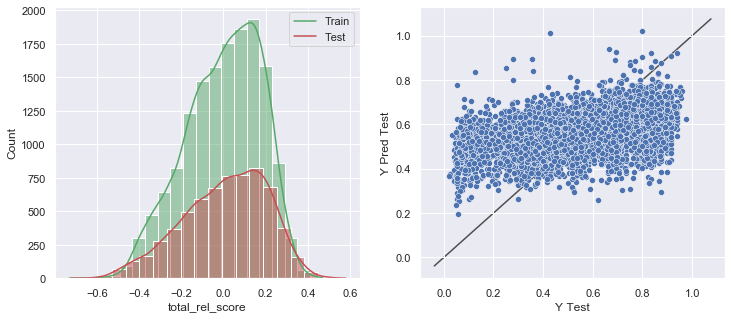

In [27]:
results_metric(model)

Training with all data:

In [28]:
%%time
full_model = BayesianRidge(verbose=True)
full_model.fit(X, y)

Convergence after  28  iterations
Wall time: 1h 20min 59s


BayesianRidge(alpha_1=1e-06, alpha_2=1e-06, alpha_init=None,
              compute_score=False, copy_X=True, fit_intercept=True,
              lambda_1=1e-06, lambda_2=1e-06, lambda_init=None, n_iter=300,
              normalize=False, tol=0.001, verbose=True)

## Predictions

Preprocessing Test dataset

In [29]:
# Creating dummy variables from OneHotEncoder created previosly...
dummy_test = dummy_language.transform(test[['Language']]).toarray()

# Converting to Dataframe with named columns for dummy
dummy_test = pd.DataFrame(dummy_test, columns=dummy_language.categories_[0])

# Scaling Year
test.Year = minMaxScaler.transform(test[['Year']])

# Joining dummy columns to full test dataset
test = test.join(dummy_test)

Saving Id column for submission csv file:

In [30]:
id = test.id

Applying NLP

In [31]:
test['abstract_title'] = test.Abstract + ' ' + test.Title

In [32]:
%%time
result_tokenization_test = get_tokens(test[['abstract_title', 'Language']])


Wall time: 20min 6s


In [34]:
test['Abstract_tokens'] = result_tokenization_test[0]
test['pos_tokens'] = result_tokenization_test[1]
test['num_sentences'] = result_tokenization_test[2]
test['num_stopwords'] = result_tokenization_test[3]
test['num_numbers'] = result_tokenization_test[4]
test['num_dets'] = result_tokenization_test[5]

In [39]:
transformed_values = vectorizer_model.transform(test['Abstract_tokens'])
test_tfidf = test.join(pd.DataFrame(transformed_values.toarray(), 
                        columns=list(map(lambda x:'token_'+x, vectorizer_model.get_feature_names())))
        )

In [40]:
transformed_values = tfidf_POS_model.fit_transform(test['pos_tokens'])
test_tfidf = test_tfidf.join(pd.DataFrame(transformed_values.toarray(), 
                        columns=list(map(lambda x:'_'+x, tfidf_POS_model.get_feature_names())))
        )

Removing same columns as train dataset:

In [41]:
test_tfidf.drop(COLS, axis=1, inplace=True)

In [42]:
test_tfidf.head()

,Year,en,es,pt,num_sentences,num_stopwords,num_numbers,num_dets,token_00,token_000,...,_noun,_num,_part,_pron,_propn,_punct,_sconj,_space,_sym,_verb
0,0.933333,1,0,0,11,68,5,25,0.0,0.0,...,0.357796,0.229092,0.092161,0.000000,0.123778,0.295472,0.000000,0.53903,0.0,0.255683
1,0.906667,1,0,0,10,73,6,23,0.0,0.0,...,0.400220,0.262282,0.257347,0.000000,0.204137,0.322562,0.000000,0.16552,0.0,0.294197
2,0.866667,1,0,0,11,106,2,26,0.0,0.0,...,0.420437,0.156042,0.096745,0.088349,0.253445,0.319365,0.098207,0.00000,0.0,0.300834
3,0.813333,0,1,0,7,54,0,20,0.0,0.0,...,0.373434,0.000000,0.000000,0.276940,0.443165,0.278121,0.110268,0.00000,0.0,0.301365
4,0.973333,1,0,0,16,112,6,33,0.0,0.0,...,0.395483,0.233076,0.183922,0.208843,0.242267,0.315091,0.186702,0.00000,0.0,0.308711


In [43]:
assert test_tfidf.shape[1] == train_tfidf.shape[1]-1, 'Number of input columns must be equal'

In [44]:
y_pred = full_model.predict(test_tfidf)
predictions = pd.DataFrame({'id':id, 'total_rel_score':y_pred})
predictions.head()

,id,total_rel_score
0,1,0.598918
1,2,0.587628
2,3,0.629299
3,4,0.576481
4,5,0.567291


In [45]:
predictions.to_csv('SampleSubmission.csv', index=False)